# **TRABAJO FINAL**
---

# **HITO 1** 
- Crear grafo para la ciudad de 1000x1000 cuadras
- Agregar la información de dataset de almacenes.csv
- Agregar la información de dataset de puntos_entrega.csv
---

## **Creación del grafo**

In [1]:
#READING CSV
import pandas as pd
from copy import deepcopy
import math

almacenes = pd.read_csv("https://raw.githubusercontent.com/billguerrerog/cc41_tf_201821590_20181B402_201811208_201823346_201823838/main/almacenes.csv")
alm = almacenes[['Coord X', 'Coord Y']]
nodeTypeALM = [1]*100
alm['NodeType'] = nodeTypeALM

puntos_entrega = pd.read_csv("https://raw.githubusercontent.com/billguerrerog/cc41_tf_201821590_20181B402_201811208_201823346_201823838/main/puntos_entrega.csv")
pe = puntos_entrega[['Coord X', 'Coord Y']]
nodeTypePE = [2]*5000
pe['NodeType'] = nodeTypePE

In [2]:
#Join both lists
newDF = pd.concat([alm, pe])

#List to use (nodeType) and list to compare (noType)
nodeTypeList = newDF[['Coord X', 'Coord Y', 'NodeType']].values.tolist()
noTypeList = newDF[['Coord X', 'Coord Y']].values.tolist()

In [3]:
#Sorting List by Y then by X
def orderList(list_):
    newL = sorted(list_, key=lambda y: y[1])
    newL.sort(key=lambda x: x[0])
    return deepcopy(newL)

newL = orderList(noTypeList)
newTypeList = orderList(nodeTypeList)

In [4]:
# Storage/DeliveryPoint Nodes to append
def popStuff(popList, times):
    to_return = []
    popList.reverse()
    for j in range(times):
        to_return.append(popList.pop())
    popList.reverse()
    return to_return

#Search X Coords Nodes (it's sorted already)
def searchX(tempList, tempNodeTypeList, x):
    returnList = []
    popped = []
    max = 0

    if len(tempList)==0 and len(tempNodeTypeList)==0:
        return returnList, popped
    for i in tempList: #Getting comparison list
        if i[0] == x:
            max += 1
            returnList.append(i)
        else:
            break
    
    popStuff(tempList, max)
    popped = []
    popped = popStuff(tempNodeTypeList, max)
    return returnList, popped

In [5]:
# Create graph
def graph(nodesList, newL_, newTypeList_):
    xList = [i for i in range(1000)]
    yList = [i for i in range(1000)]
    nodesCont = 0

    tempNoTypeList = deepcopy(newL_)
    tempTypeList = deepcopy(newTypeList_)

    for x in xList:
        smallList = [] #Comparison list
        popped = [] #To List
        if len(tempNoTypeList)>0 and len(tempTypeList)>0:
            smallList, popped = searchX(tempNoTypeList, tempTypeList, x)
        for y in yList:
            ady1 = nodesCont - 1000 #left then goes clockwise
            ady2 = nodesCont - 1
            ady3 = nodesCont + 1000
            ady4 = nodesCont + 1
            # Validations - not corners
            if x == 0: ady1 = -1
            if x == 999: ady3 = -1
            if y == 0: ady2 = -1
            if y == 999: ady4 = -1

            ady0 = [ady1, ady2, ady3, ady4]

            if len(popped) > 0 and len(smallList) > 0 and [x, y] in smallList:
                t = popped.pop(0)
                nodesList.append([t[0], t[1], t[2], ady0])
            else:
                nodesList.append([x, y, 0, ady0])
            
            nodesCont += 1

In [6]:
# Creating the new graph
nodes = []
graph(nodes, newL, newTypeList)

## **Visualización del grafo**

In [7]:
# Making a copy of resulting graph
nodes_copy = deepcopy(nodes)

In [8]:
#Methods to show graph
def popStuffAndDelete(popList, times):
    to_return = []
    popList.reverse()
    for j in range(times):
        popped = popList.pop()
        del popped[3]
        del popped[2]
        to_return.append(popped)
    popList.reverse()
    return to_return

def deleteStuff(nodesList):
    for i in nodesList:
        del i[3]
        del i[2]

def separateTypes(tempNodes, x):
    max = 0
    for i in tempNodes:
        if i[2] == x:
            max += 1
        else:
            popped = popStuffAndDelete(tempNodes, max)
            return popped

In [9]:
#Copies to show graph
new_nodes = sorted(nodes_copy, key=lambda y: y[2])
new_nodes_copy = deepcopy(new_nodes)

normal_nodes = separateTypes(new_nodes_copy, 0)
alm_nodes = separateTypes(new_nodes_copy, 1)
ent_nodes = new_nodes_copy
deleteStuff(ent_nodes)

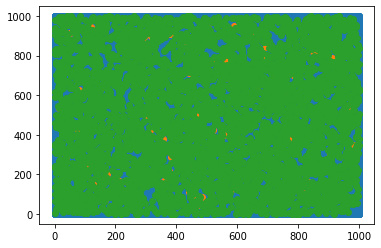

In [10]:
import matplotlib.pyplot as plt
import numpy as np

#Show graph
normal_np = np.array(normal_nodes)
alm_np = np.array(alm_nodes)
ent_np = np.array(ent_nodes)

plt.scatter(*zip(*normal_np))
plt.scatter(*zip(*alm_np))
plt.scatter(*zip(*ent_np))

cm = 1/2.54
plt.rcParams["figure.figsize"] = [60*cm, 30*cm]
plt.rcParams["figure.autolayout"] = True
plt.show()

# **HITO 2** 
- Implementar algoritmo Dijkstra al grafo generado
- Implementar Dijkstra desde cada almacén a todos los puntos de entrega
- Algoritmo para repartir puntos de entrega entre almacenes, de acuerdo a cercanía (Parte del Hito 3)

### Nota: Los algoritmos del hito 2 han sido modificados de acuerdo al hito 3
---

In [11]:
# Making a copy of resulting graph
nodes_copy = deepcopy(nodes)

In [12]:
# BFS since all edges have the same weight (from a node)
def bfs(graph, s, size):
    visited = [False]*size
    parent = [None]*size
    queue = [s]
    visited[s] = True

    while queue:
        u = queue.pop(0)
        node = graph[u]
        for v in node[3]:
            if v >= 0:
                if not visited[v]:
                    visited[v] = True
                    parent[v] = u
                    queue.append(v)

    return parent

def find_route(all_routes, alm_node, ent_node):
    start_node = all_routes[ent_node] #returns parent
    #ir desde ent_node hasta alm_node con un while, hasta que encuentre el nodo que necesita
    #Las rutas se obtienen recorriendo las rutas generales de manera inversa
    route = []
    route.append(ent_node)

    if start_node == alm_node: #Comprueba si son nodos adyacentes
        route.append(alm_node)
        route.reverse()
        return route

    while start_node != alm_node: #Recorre los padres desde el punto de entrega hasta el almacén (inversamente)
        route.append(start_node)
        start_node = all_routes[start_node]

    route.append(alm_node)
    route.reverse()
    return route #returns 1 route

def get_coords(i):
    z = 1000
    x = i//z
    y = i % z
    return x, y

def get_node(x, y):
    return (x*1000) + y

def get_distance(alm_node, ent_node):
    alm_x, alm_y = get_coords(alm_node)
    ent_x, ent_y = get_coords(ent_node)
    return math.sqrt((ent_x - alm_x)**2 + (ent_y - alm_y)**2)

def find_nodes(graph, node_type, max):
    nodes = []
    cont_ent = 0
    size = len(graph)
    for i in range(size):
        if graph[i][2] == node_type:
            nodes.append(i)
            cont_ent += 1
        if cont_ent == max:
            return nodes #returns all nodes of that type

In [13]:
def find_shorter_route(graph, alm_node, size, ent_nodes_list, routes, shortest_routes):
    parent = bfs(graph, alm_node, size)

    for i in range(len(ent_nodes_list)): #ent_nodes
        route = []
        route.append(alm_node)
        route.append(ent_nodes_list[i])
        #check_route = find_route(parent, alm_node, ent_nodes_list[i])
        check_distance = get_distance(alm_node, ent_nodes_list[i]) #Closest to Storage Point
        if len(shortest_routes) < len(ent_nodes_list): # Empty list
            routes.append(route)
            shortest_routes.append(check_distance)
        else:
            #if len(check_route) < len(shortest_routes[i]): #Check if it's a shorter route
            if check_distance < shortest_routes[i]:
                routes[i] = route
                shortest_routes[i] = check_distance # Replace if so

def pop_asigned_delivery(ordered_list, storage_point):
    delivery_points = []
    for j in range(len(ordered_list)):
        if ordered_list[-1][0] == storage_point:
            aux = ordered_list.pop()
            delivery_points.append(aux[1])
            if len(ordered_list) == 0:
                return delivery_points
        else:
            return delivery_points

def shortest_routes(graph, size): #Only asking to every Storage node
    routes = []
    shortest_routes = []
    cont_alm = 0
    alm_nodes_list = find_nodes(graph, 1, 100) #alm = 1 / ent = 2
    ent_nodes_list = find_nodes(graph, 2, 5000) #alm = 1 / ent = 2

    for i in range(len(alm_nodes_list)):
        find_shorter_route(graph, alm_nodes_list[i], size, ent_nodes_list, routes, shortest_routes)

    #Order by Storage Point
    ordered_by_alm = sorted(routes, key=lambda a: a[0], reverse=True)
    by_alm = []
    for i in alm_nodes_list:
        asigned_delivery_points = []
        asigned_delivery_points = pop_asigned_delivery(ordered_by_alm, i)
        aux = []
        aux.append(i)
        aux.append(asigned_delivery_points)
        by_alm.append(aux)

    return by_alm #100 storage points with its assigned delivery points

In [14]:
#Takes 3 mins
asigned_delivery_points = shortest_routes(nodes_copy, len(nodes_copy))

In [15]:
#Show assigned delivery points to every storage point (Commented to not overload content)
# for i in range(100):
#     print(asigned_delivery_points[i])

# **HITO 3**
- Creación de regiones a partir de los puntos de entrega más cercanos a cada almacén
- Algoritmo Dijkstra para cada almacén, ahora a sus puntos cercanos
---

## **Creación de las regiones de distribución de cada almacén**

---

In [16]:
#Get single region
def get_region(alm, asigned_delivery):
    min_x, min_y = get_coords(alm) # Start
    max_x, max_y = get_coords(alm) # Start
    for i in asigned_delivery: #Getting min and max coords to create region
        delivery_x, delivery_y = get_coords(i) #Coords to compare
        if delivery_x < min_x: #Check min X
            min_x = delivery_x
        elif delivery_x > max_x: #Check max X
            max_x = delivery_x
        if delivery_y < min_y: #Check min Y
            min_y = delivery_y
        elif delivery_y > max_y: #Check max Y
            max_y = delivery_y

    min_max = [min_x, min_y, max_x, max_y]
    return min_max

# Get Regions
def all_regions_coords(asigned_stuff):
    regions = []
    for i in asigned_stuff:
        aux = []
        region = get_region(i[0], i[1])
        aux.append(i[0])
        aux.append(region) #Region coords
        regions.append(aux)
    
    return regions

In [17]:
regions = all_regions_coords(asigned_delivery_points)

In [18]:
import heapq as hq

def adjacencies(region): #Create region adjacencies
    xList = [i for i in range(region[0], region[2] + 1)]
    yList = [i for i in range(region[1], region[3] + 1)]

    nodes_region = {}

    for x in xList:
        for y in yList:
            nodes_region[get_node(x, y)] = []
    
    for node in nodes_region:
            ady1 = node - 1000 #left then goes clockwise
            ady2 = node - 1
            ady3 = node + 1000
            ady4 = node + 1

            ady0 = [ady1, ady2, ady3, ady4]
            for i in ady0:
                if i in nodes_region:
                    nodes_region[node].append(i)
    
    return nodes_region

def new_dijkstra(graph, start):
    visited = {}
    parent = {}
    cost = {}
    queue = [(start, 0)]
    for i in graph.keys():
        visited[i] = False
        parent[i] = None
        cost[i] = math.inf
    
    cost[start] = 0

    while queue:
        u, g_u = hq.heappop(queue)
        if not visited[u]:
            visited[u] = True
            for v in graph[u]:
                f = g_u + 1 #No cost
                if f < cost[v]:
                    cost[v] = f
                    parent[v] = u
                    hq.heappush(queue, (v, f))

    return parent

def all_regions(regions):
    routes = []
    regions_adj = []

    for i in range(len(regions)):
        alm, region = regions[i]
        nodes = adjacencies(region)

        route = new_dijkstra(nodes, alm)
        routes.append(route)
        
        regions_adj.append(nodes)

    return routes, regions_adj

In [19]:
routes, regions_adj = all_regions(regions)

In [20]:
##Show routes generated by Dijkstra Algorithm (commented to not overload file)
# for i in range(3):
#     print(routes[i])
# print(len(routes))

In [21]:
##Show all regions generated for every storage point (commented to not overload file)
# for i in range(20): #100 to show all of them
#     print(regions[i])
# print(len(regions))

## **Visualización de las regiones de cada almacén**

---

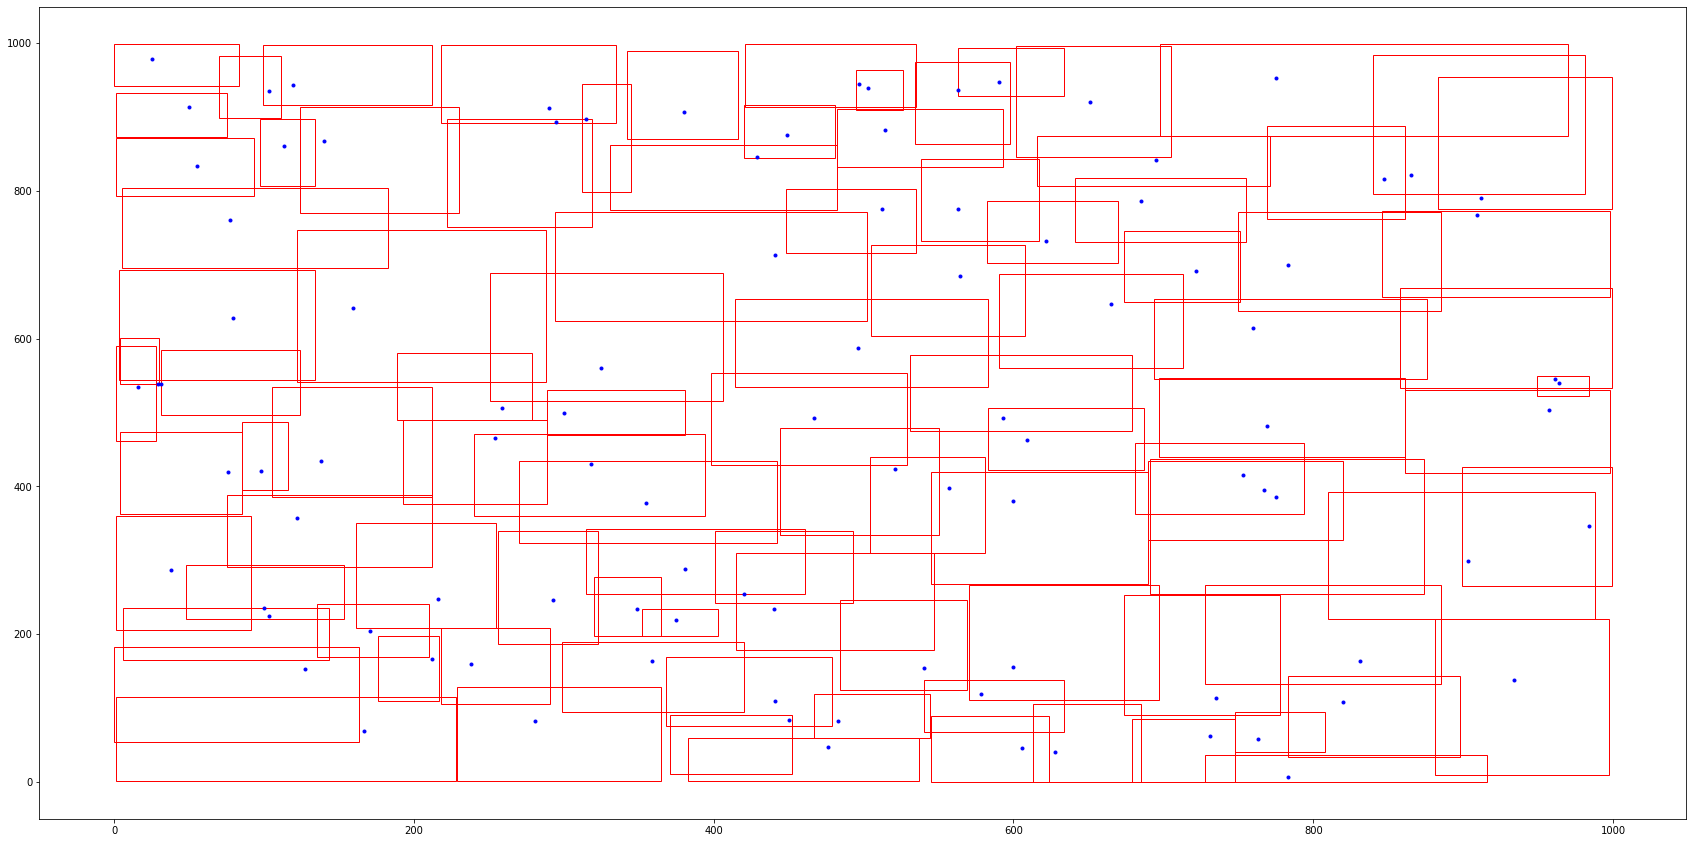

In [22]:
import matplotlib.patches as patches

fig, ax = plt.subplots()

for i in range(100):
    clr = 'red'
    min_x = regions[i][1][0]
    min_y = regions[i][1][1]
    max_x = regions[i][1][2]
    max_y = regions[i][1][3]
    rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    cm = 1/2.54
    plt.rcParams["figure.figsize"] = [60*cm, 30*cm]
    alm_x, alm_y = get_coords(regions[i][0])
    plt.plot(alm_x, alm_y, '.', color='blue')
    plt.rcParams["figure.autolayout"] = True
    plt.plot

plt.show()

In [23]:
def get_my_region(all_regions, member_number):
    regions_size = int(len(all_regions)/5)
    min = member_number*regions_size
    max = (member_number + 1)*regions_size
    member_regions = []
    for i in range(min, max):
        member_regions.append(all_regions[i])

    return member_regions

# **HITO 4**
- Implementación de algoritmos individuales (primera, segunda y última versión)

---

## **ALGORITMO 1 - Bill Guerrero González - u201821590**

---

In [223]:
def algorithm_1(graph, start):
    visited = {}
    parent = {}
    for i in graph:
        visited[i] = False
        parent[i] = None
    
    queue = [start]

    while queue:
        u = queue.pop(0)
        for v in graph[u]:
            if not visited[v]:
                visited[v] = True
                parent[v] = u
                queue.append(v)

    return parent

def my_routes_1(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_1(nodes, alm)
        routes.append(route)

    return routes

my_regions_1 = get_my_region(regions, 0)
my_regions_routes_1 = my_routes_1(my_regions_1)

##Show routes of region 1 (commented to not overload file)
# for i in range(3):
#     print(my_regions_routes_1[i])
# print(len(my_regions_routes_1))

## **ALGORITMO 2 - Josue Cuentas Jave - U20181B402**

---

In [224]:
#Second version
def algorithm_2(graph, start):
  visited = {}
  parent = {}

  for i in graph:
    visited[i] = False
    parent[i] = None

  stack = [start]
  flag = 0
  while stack:
    u = stack.pop()
    if not visited[u]:
      visited[u] = True
      for v in graph[u]:
        if not visited[v]:
          parent[v] = u
          stack.append(v)

  return parent

def my_routes_2(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_2(nodes, alm)
        routes.append(route)

    return routes

my_regions_2 = get_my_region(regions, 1)
my_regions_routes_2 = my_routes_2(my_regions_2)

##Show routes of region 2 (commented to not overload file)
# for i in range(3):
#     print(my_regions_routes_2[i])
# print(len(my_regions_routes_2))

## **ALGORITMO 3 - José Ivan Tarazona Ildefonso - u201823346**

---

In [225]:
def algorithm_3(graph, start):
  visited = {}
  path = {}
  cost = {}
  for key in graph.keys():
    visited[key] = False
    path[key] = None
    cost[key] = math.inf

  cost[start] = 0
  queue = [(start, 0)]
  while queue:
    u, g_u = hq.heappop(queue)
    if not visited[u]:
      visited[u] = True
      for v in graph[u]:
        f = g_u + 1
        if f < cost[v]:
          cost[v] = f
          path[v] = u
          hq.heappush(queue, (v, f))
  return path

def my_routes_3(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_3(nodes, alm)
        routes.append(route)

    return routes

my_regions_3 = get_my_region(regions, 2)
my_regions_routes_3 = my_routes_3(my_regions_3)

##Show routes of region 3 (commented to not overload file)
# for i in range(3):
#     print(my_regions_routes_3[i])
# print(len(my_regions_routes_3))

## **ALGORITMO 4 - Sebastian Santiago Alfaro Mendoza - u201811208**

In [226]:
def algorithm_4(graph, start):
  visited = {}
  path = {}
  cost = {}
  for key in graph.keys():
    visited[key] = False
    path[key] = None
    cost[key] = float('inf')
  cost[start] = 0
  q = [(0, start)]
  while q:
    i, u = hq.heappop(q)
    if not visited[u]:
      visited[u] = True
      for v in graph[u]:
        if not visited[v] and 1 < cost[v]:
          cost[v] = 1
          path[v] = u
          hq.heappush(q, (1, v))

  return path


def my_routes_4(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_4(nodes, alm)
        routes.append(route)

    return routes

my_regions_4 = get_my_region(regions, 3)
my_regions_routes_4 = my_routes_4(my_regions_4)

##Show routes of region 4 (commented to not overload file)
# for i in range(3):
#     print(my_regions_routes_4[i])
# print(len(my_regions_routes_4))

## **ALGORITMO 5 - José Adrian Pain Peralta - u201823838**

In [227]:
#Create a fibonnaci heap with dictionary
def fibonnaciheap(key, value):
    #create a dictionary
    fibonnaciheap = {}
    #create a list
    fibonnaciheap[key] = value
    return fibonnaciheap

def popFib(fibonnaciheap):
    lastelt = fibonnaciheap.pop()
    if fibonnaciheap:
        returnitem = fibonnaciheap[0]
        fibonnaciheap[0] = lastelt
        _siftup(fibonnaciheap, 0)
        return returnitem
    return lastelt

def pushFib(fibonnaciheap, item):
    fibonnaciheap.append(item)
    _siftdown(fibonnaciheap, 0, len(fibonnaciheap)-1)

def _siftdown(fibonnaciheap, startpos, pos):
    newitem = fibonnaciheap[pos]
    while pos > startpos:
        parentpos = (pos - 1) >> 1
        parent = fibonnaciheap[parentpos]
        if newitem < parent:
            fibonnaciheap[pos] = parent
            pos = parentpos
            continue
        break
    fibonnaciheap[pos] = newitem

def _siftup(fibonnaciheap, pos):
    endpos = len(fibonnaciheap)
    startpos = pos
    newitem = fibonnaciheap[pos]
    childpos = 2*pos + 1
    while childpos < endpos:
        rightpos = childpos + 1
        if rightpos < endpos and not fibonnaciheap[childpos] < fibonnaciheap[rightpos]:
            childpos = rightpos
        fibonnaciheap[pos] = fibonnaciheap[childpos]
        pos = childpos
        childpos = 2*pos + 1
    fibonnaciheap[pos] = newitem
    _siftdown(fibonnaciheap, startpos, pos)

In [228]:
def algorithm_5(graph, start):
    visited = {}
    parent = {}
    cost = {}
    fheap1 = [(start, 0)]
    for key in graph.keys():
        visited[key] = False
        parent[key] = None
        cost[key] = math.inf

    cost[start] = 0
    while fheap1:
        u, g_u = popFib(fheap1)
        if not visited[u]:
            visited[u] = True
            for v in graph[u]:
                f = g_u + 1 #No cost
                if f < cost[v]:
                    cost[v] = f
                    parent[v] = u
                    pushFib(fheap1, (v, f))
    return parent

def my_routes_5(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_5(nodes, alm)
        routes.append(route)

    return routes


my_regions_5 = get_my_region(regions, 4)
my_regions_routes_5 = my_routes_5(my_regions_5)

##Show routes of region 5 (commented to not overload file)
# for i in range(3):
#     print(my_regions_routes_5[i])
# print(len(my_regions_routes_5))

# **DEMOSTRACIÓN TF**
- Demostración de las rutas generadas en cada región
---

In [218]:
def find_route_storage_to_delivery(region_routes, storage, delivery):
    start_node = region_routes[delivery] #First parent

    route = []
    route.append(delivery)
    if start_node == storage: #Comprueba si son nodos adyacentes
        route.append(storage)
        route.reverse()
        return route

    while start_node != storage:
        route.append(start_node)
        start_node = region_routes[start_node]

    route.append(storage)
    route.reverse()
    return route

In [219]:
def storage_and_deliveries_to_dict(assigned_delivery_list): #Turn assigned delivery list to dict, to use keys
    ret_dict = {}
    for i in assigned_delivery_list: #Get storage points
        ret_dict[i[0]] = i[1]
    return ret_dict

In [220]:
# {"Storage1": {"Delivery1": [route], "Delivery2": [route]}, "Storage2": {"Delivery1": [route]}}
def find_routes_for_all_storages(assigned_delivery_list, my_regions_routes):
    assigned_delivery_dict = storage_and_deliveries_to_dict(asigned_delivery_points)

    storage_routes_dict = {}
    cont = 0
    for storage in assigned_delivery_dict.keys(): #Get by storage
        delivery_routes_dict = {}
        for delivery in assigned_delivery_dict[storage]: #Get by delivery
            #send to find specific route
            delivery_routes_dict[delivery] = find_route_storage_to_delivery(my_regions_routes[cont], storage, delivery)
        storage_routes_dict[storage] = delivery_routes_dict
        cont += 1
    
    return storage_routes_dict

In [221]:
#Join all routes
my_regions_routes_1.extend(my_regions_routes_2)
my_regions_routes_1.extend(my_regions_routes_3)
my_regions_routes_1.extend(my_regions_routes_4)
my_regions_routes_1.extend(my_regions_routes_5)

#Get all routes from regions
routes_dict = find_routes_for_all_storages(asigned_delivery_points, my_regions_routes_1)

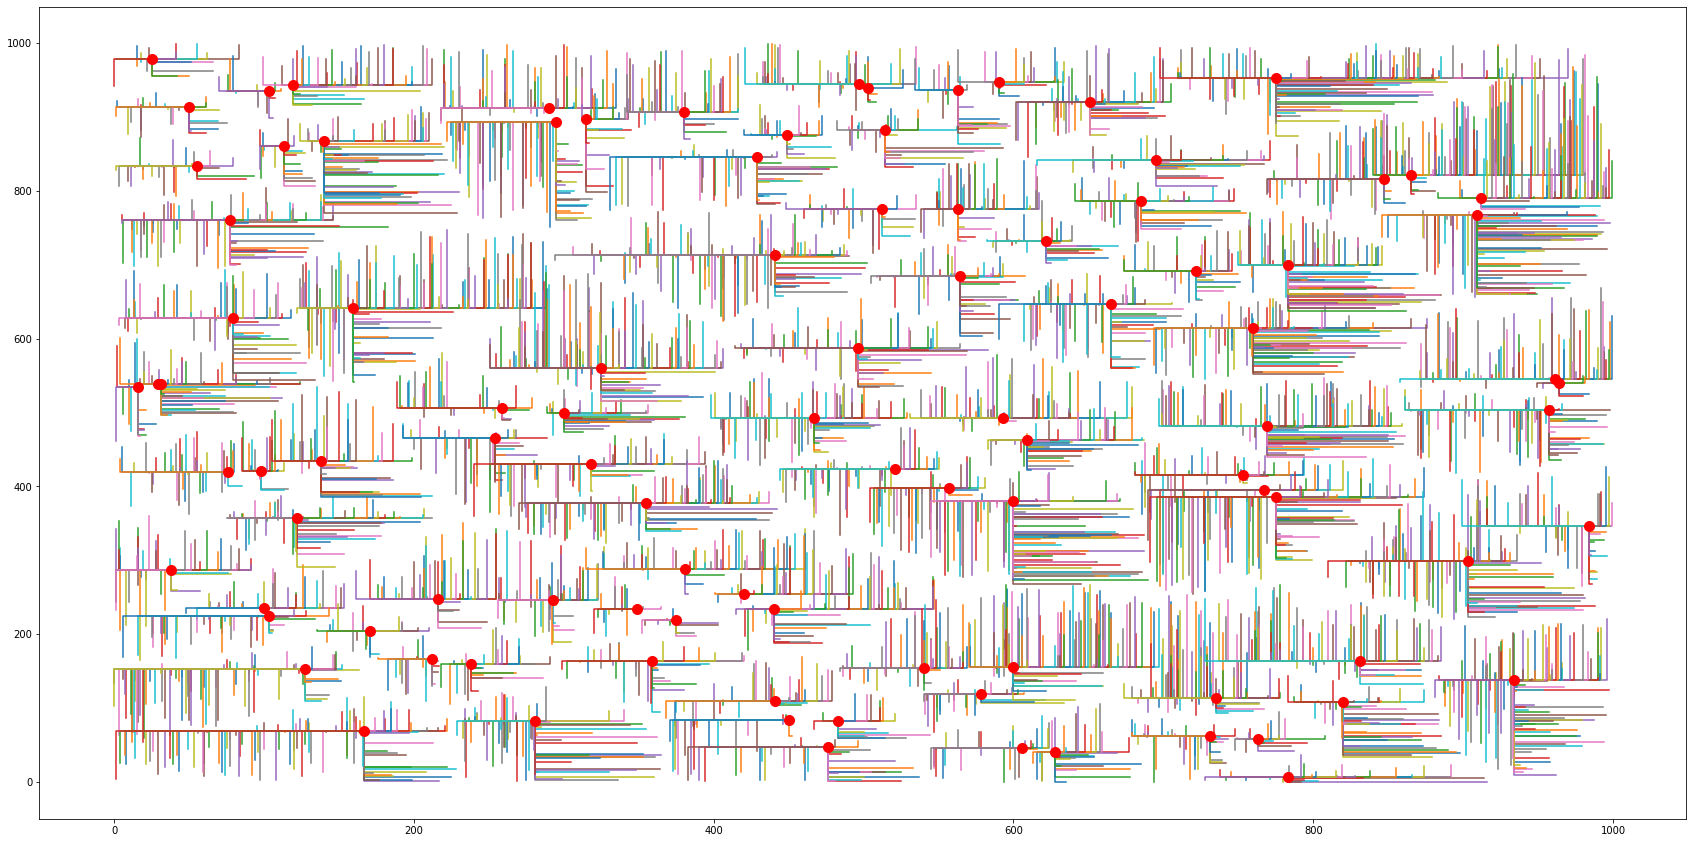

In [222]:
import numpy as np
import matplotlib.pyplot as plt

def get_alm_coords_from_dict(from_dict):
    alm_coords_list = []
    for i in routes_dict.keys():
        x, y = get_coords(i)
        aux = [x, y]
        alm_coords_list.append(aux)
    return alm_coords_list

alm_nodes_list = get_alm_coords_from_dict(routes_dict)

regions_routes_to_coords = []
for storage in routes_dict.keys():
    region_route_to_coords = []
    for delivery in routes_dict[storage]:
        route_to_delivery = []
        for point in routes_dict[storage][delivery]:
            x, y = get_coords(point)
            aux = [x, y]
            route_to_delivery.append(aux)
        region_route_to_coords.append(route_to_delivery)
    regions_routes_to_coords.append(region_route_to_coords)

# Show regions routes
for i in regions_routes_to_coords:
    for j in i:
        data = np.array(j)
        plt.plot(*data.T)

#Show storage points
for i in alm_nodes_list:
    plt.plot(i[0], i[1],marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")

plt.show()